## Урок 2: Построение надежной локальной валидации

Задание на повторение:
Задание не обязательно к выполнению, но очень рекомендуется для понимания набора данных и получения гипотез для проведения валидации.
* Задание 1: Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.
* Задание 2: построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.
* Задание 3: построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.
* Задание 4: построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

Основное задание:
Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud. Рекомендуется использовать модели градиетного бустинга, реализация любая.

* Задание 1: сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на тестовой выборке, оценить расхождение по сравнению с качеством на обучающей выборке и тестовой выборке.

* Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1.

* Задание 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на тестовом выборке относительно полученного доверительного интервала. Сделать выводы.

* Задание 4: выполнить Adversarial Validation на основе данных из обучения / теста, подобрать объема из обучающей выборки, которые сильно похожи на объекты из тестовой выборки, и использовать их в качестве валидационного набора. Сделать выводы о полученных результатах.

* Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных;

* Задание 6 * (опциональное): сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на тестовой выборке с полученным доверительным интервалом. Сделать выводы.

* Задание 7 ** (совсем опциональное): в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).

In [229]:
import warnings
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb
import matplotlib.pyplot as plt

from scipy.stats import probplot, ttest_rel
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
warnings.simplefilter("ignore")
%matplotlib inline

### Загрузка данных

In [230]:
test = pd.read_csv("assignment_test.csv")
test.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3062000,0,1643492,41.0,W,9500,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3062001,1,1643513,161.0,W,6668,390.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [231]:
train = pd.read_csv("assignment_train.csv")
train.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [232]:
print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 50001 rows, 394 cols
test.shape = 75000 rows, 394 cols


In [233]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.000100e+04,50001.000000,5.000100e+04,50001.000000,50001.000000,49304.000000,49998.000000,49766.000000,47410.000000,47410.000000,...,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000
mean,3.012000e+06,0.027139,6.378101e+05,128.129726,9912.598368,366.635547,152.803612,200.704276,291.813162,85.590593,...,0.110450,38.942391,63.051814,45.816241,4.252527,14.926426,7.991718,15.742603,21.362671,16.464481
std,1.443419e+04,0.162491,3.229461e+05,213.078011,4904.597980,159.057800,10.482210,40.299048,104.991697,6.687334,...,0.469788,190.465893,446.405097,210.319262,46.694625,105.561868,60.584452,91.083819,131.071046,92.726771
min,2.987000e+06,0.000000,8.640000e+04,0.292000,1001.000000,100.000000,100.000000,100.000000,100.000000,13.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.999500e+06,0.000000,3.523050e+05,42.000000,6019.000000,208.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.012000e+06,0.000000,6.537500e+05,68.500000,9705.000000,369.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.024500e+06,0.000000,9.321340e+05,120.000000,14265.000000,514.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.037000e+06,1.000000,1.189349e+06,4829.950000,18393.000000,600.000000,229.000000,237.000000,540.000000,102.000000,...,7.000000,6300.000000,32250.000000,6300.000000,1000.000000,2700.000000,1300.000000,1700.000000,3000.000000,1700.000000


In [234]:
target = "isFraud"

### Задание на повторение: Задание не обязательно к выполнению, но очень рекомендуется для понимания набора данных и получения гипотез для проведения валидации.

#### Задание 1: 
Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

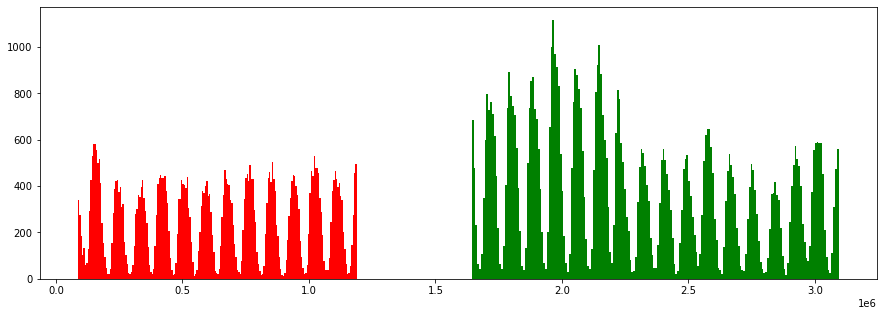

In [235]:
plt.figure(figsize=(15,5))
plt.hist(train['TransactionDT'], color='red', bins=200)
plt.hist(test['TransactionDT'], color='green', bins=200)
plt.show()

Трейн и тест разбиты по времени, причём отделены друг от друга с некоторым разрывом. Трейн имеет более ранние даты чем тест. На обеих выборках наблюдается сезонность.

#### Задание 2: 
Построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

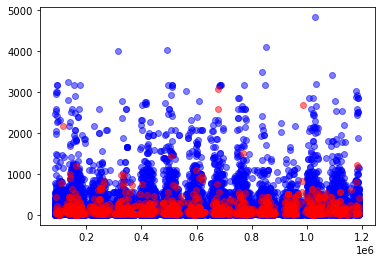

In [236]:
plt.scatter(train[train[target]==0]['TransactionDT'], train[train[target]==0]['TransactionAmt'], color='blue', alpha=0.5)
plt.scatter(train[train[target]==1]['TransactionDT'], train[train[target]==1]['TransactionAmt'], color='red', alpha=0.5)
plt.show()

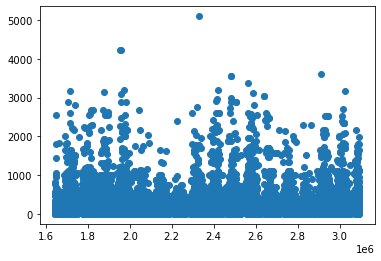

In [237]:
plt.scatter(test['TransactionDT'], test['TransactionAmt'])
plt.show()

Наборы данных тест и трейн довольно похожи друг на друга. На трейн выборке мошеннические операции сгруппированы и видимо совпадают со временем проведения обычных операций. Мошеннические операции проводятся небольшими суммами.

#### Задание 3: 
Построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

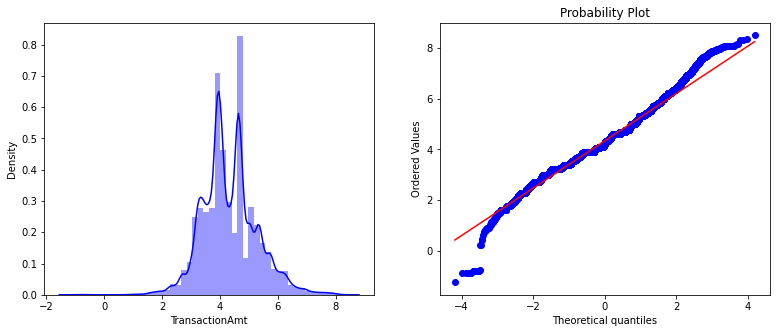

In [238]:
data = np.log(train['TransactionAmt'])
fig = plt.figure(figsize=(13, 5))
plt.subplot(121)
sns.distplot(data, bins=50, color="blue")
plt.subplot(122)
probplot(data, plot=plt)
plt.show()

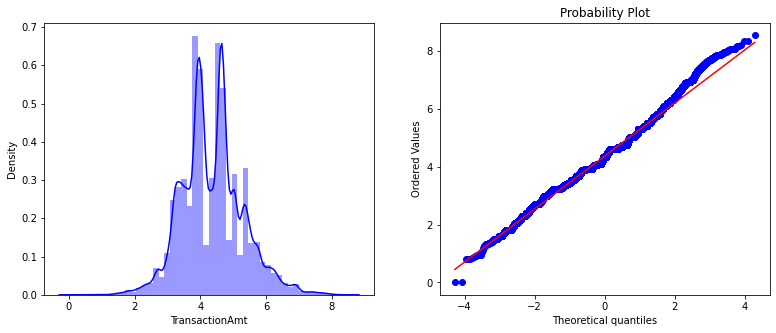

In [239]:
data = np.log(test['TransactionAmt'])
fig = plt.figure(figsize=(13, 5))
plt.subplot(121)
sns.distplot(data, bins=50, color="blue")
plt.subplot(122)
probplot(data, plot=plt)
plt.show()

Распределения на трейн и тест похожи, но не являются нормальными.

#### Задание 4: 
Построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

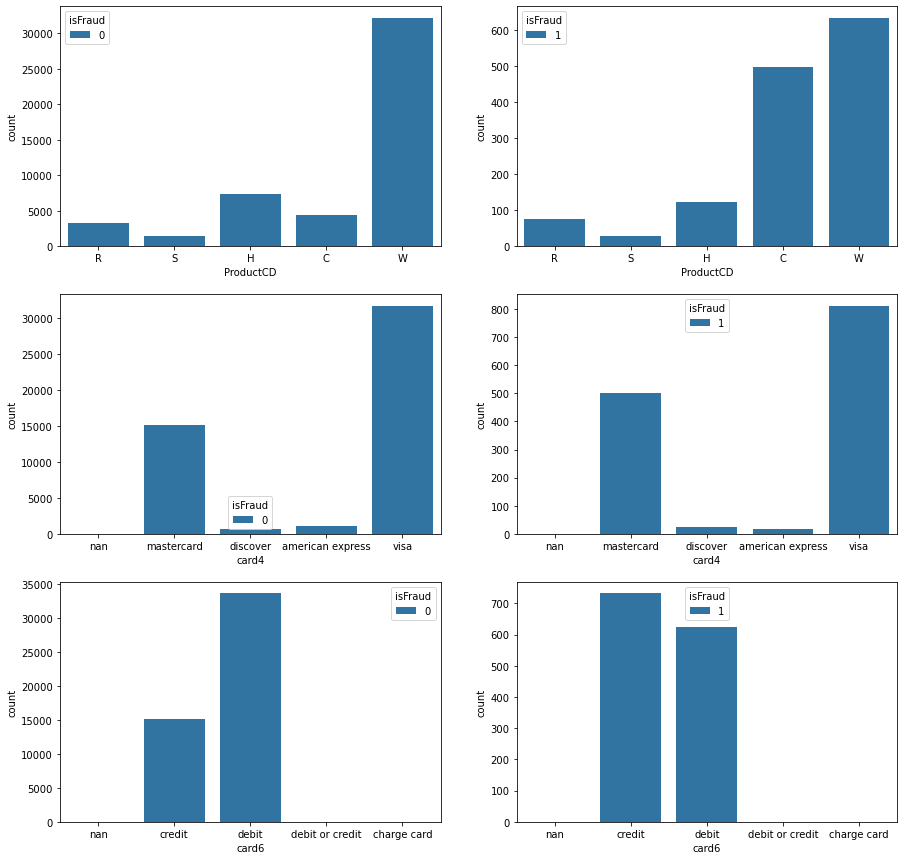

In [240]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for i, feature in enumerate(['ProductCD', 'card4', 'card6']):
    order = set(train[feature])
    sns.countplot(data=train[train[target]==0], x=feature, hue=target, ax=ax[i, 0], order=order)
    sns.countplot(data=train[train[target]==1], x=feature, hue=target, ax=ax[i, 1], order=order)
fig.show()

Распределения для обычных и мошеннических операций для ProductCD отличаются. В частности класс C имеет значительно больше мошеннических операций. Для card4 распределения похожи. Для card6 распределения отличаются: для кредитных карт мошеннических операций больше чем по дебетовым.

#### Задание 1: 
сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на тестовой выборке, оценить расхождение по сравнению с качеством на обучающей выборке и тестовой выборке.

In [241]:
cat_features = train.select_dtypes("object").columns.tolist()
drop_features = [target, 'TransactionID', 'TransactionDT']

In [242]:
train[cat_features] = train[cat_features].astype(str)
test[cat_features] = test[cat_features].astype(str)

In [243]:
x_train, x_valid = train_test_split(train.drop(drop_features, axis=1), train_size=0.7, shuffle=True, random_state=1)
y_train, y_valid = train_test_split(train[target], train_size=0.7, shuffle=True, random_state=1)
x_public = test.drop(drop_features, axis=1)
y_public = test[target]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_public.shape = {} rows, {} cols".format(*x_public.shape))

x_train.shape = 35000 rows, 391 cols
x_valid.shape = 15001 rows, 391 cols
x_public.shape = 75000 rows, 391 cols


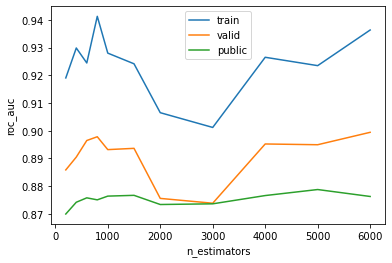

Wall time: 3min 14s


In [258]:
%%time
train_score = []
valid_score = []
public_score = []
eval_set = [(x_valid, y_valid)]
n_estimators = [200, 400, 600, 800, 1000, 1500, 2000, 3000, 4000, 5000, 6000]

for e in n_estimators:
    model = catb.CatBoostClassifier(cat_features=cat_features, eval_metric='AUC', n_estimators=e, max_depth=5,
                                    early_stopping_rounds=10, silent=True, random_state=1)
    model.fit(x_train, y_train, eval_set=eval_set)
    train_score.append(roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]))
    valid_score.append(roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1]))
    public_score.append(roc_auc_score(y_public, model.predict_proba(x_public)[:, 1]))
    
plt.plot(n_estimators, train_score, label='train')
plt.plot(n_estimators, valid_score, label='valid')
plt.plot(n_estimators, public_score, label='public')
plt.xlabel('n_estimators')
plt.ylabel('roc_auc')
plt.legend()
plt.show()

При увеличении числа деревьев точность на паблик-выборке растёт стабильно только в самом начале, а при большом количестве деревьев начинает варьироваться. При этом точность на train довольно далеко находится от точности на valid и test.

#### Задание 2: 
Сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1.

In [259]:
x_train, x_valid = train_test_split(train.drop(drop_features, axis=1), train_size=0.6, shuffle=True, random_state=1)
y_train, y_valid = train_test_split(train[target], train_size=0.6, shuffle=True, random_state=1)
x_valid, x_test = train_test_split(x_valid, train_size=0.5, random_state=1, shuffle=True)
y_valid, y_test = train_test_split(y_valid, train_size=0.5, random_state=1, shuffle=True)
x_public = test.drop(drop_features, axis=1)
y_public = test[target]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))
print("x_public.shape = {} rows, {} cols".format(*x_public.shape))

x_train.shape = 30000 rows, 391 cols
x_valid.shape = 10000 rows, 391 cols
x_test.shape = 10001 rows, 391 cols
x_public.shape = 75000 rows, 391 cols


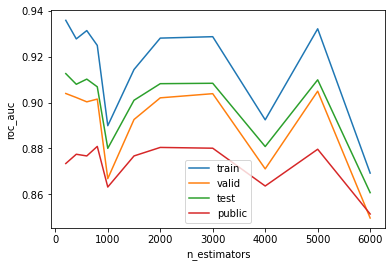

Wall time: 2min 28s


In [260]:
%%time
train_score = []
valid_score = []
test_score = []
public_score = []
eval_set = [(x_valid, y_valid)]
n_estimators = [200, 400, 600, 800, 1000, 1500, 2000, 3000, 4000, 5000, 6000]

for e in n_estimators:
    model = catb.CatBoostClassifier(cat_features=cat_features, eval_metric='AUC', n_estimators=e, max_depth=5,
                                    early_stopping_rounds=10, silent=True, random_state=1)
    model.fit(x_train, y_train, eval_set=eval_set)
    train_score.append(roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]))
    valid_score.append(roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1]))
    test_score.append(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]))
    public_score.append(roc_auc_score(y_public, model.predict_proba(x_public)[:, 1]))
    
plt.plot(n_estimators, train_score, label='train')
plt.plot(n_estimators, valid_score, label='valid')
plt.plot(n_estimators, test_score, label='test')
plt.plot(n_estimators, public_score, label='public')
plt.xlabel('n_estimators')
plt.ylabel('roc_auc')
plt.legend()
plt.show()

Ситуация с варьированием точности лучше не стала. Зато теперь метрики на разных выборках стали ближе друг к другу. При этом при увеличении/уменьшении точности на трейне соответственно увеличивается/уменьшается и точность на других выборках. И точность подросла.

#### Задание 3: 
Построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на тестовом выборке относительно полученного доверительного интервала. Сделать выводы.

In [261]:
model = catb.CatBoostClassifier(cat_features=cat_features, eval_metric='AUC', n_estimators=800, max_depth=5,
                                early_stopping_rounds=10, silent=True, random_state=1)
model.fit(x_train, y_train, eval_set=eval_set)

In [262]:
print(roc_auc_score(y_public, model.predict_proba(x_public)[:, 1]))

0.8808619076271061


In [263]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [264]:
np.random.seed(1)
scores = create_bootstrap_metrics(y_test, model.predict_proba(x_test)[:, 1], roc_auc_score)
calculate_confidence_interval(scores)

(0.8845249225155764, 0.9293051865940797)

Text(0.5, 0, 'sampel number')

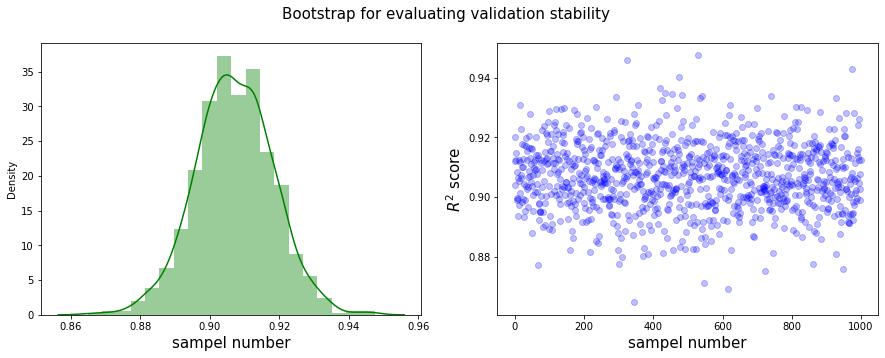

In [265]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sampel number", size=15)
axes[1].set_ylabel("$R^2$ score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sampel number", size=15)

Доверительный интервал получился довольно широким, при этом значение метрики на публичном борде не попало в доверительный интервал. Модель валидации получилась не очень хорошей.

#### Задание 4: 
Выполнить Adversarial Validation на основе данных из обучения / теста, подобрать объема из обучающей выборки, которые сильно похожи на объекты из тестовой выборки, и использовать их в качестве валидационного набора. Сделать выводы о полученных результатах.

In [266]:
X_adv = pd.concat([train, test])
y_adv = np.hstack((np.ones(train.shape[0]), np.zeros(test.shape[0])))
X_adv = X_adv.reset_index(drop=True)
X_adv = X_adv.drop(drop_features, axis=1)

In [268]:
%%time
model = catb.CatBoostClassifier(cat_features=cat_features, eval_metric='AUC', n_estimators=800, max_depth=5,
                                early_stopping_rounds=10, silent=True, random_state=1)
model.fit(X_adv, y_adv)

Wall time: 1min 7s


Text(0.5, 1.0, 'Top Importance Features for Adversarial Validation (train vs test)')

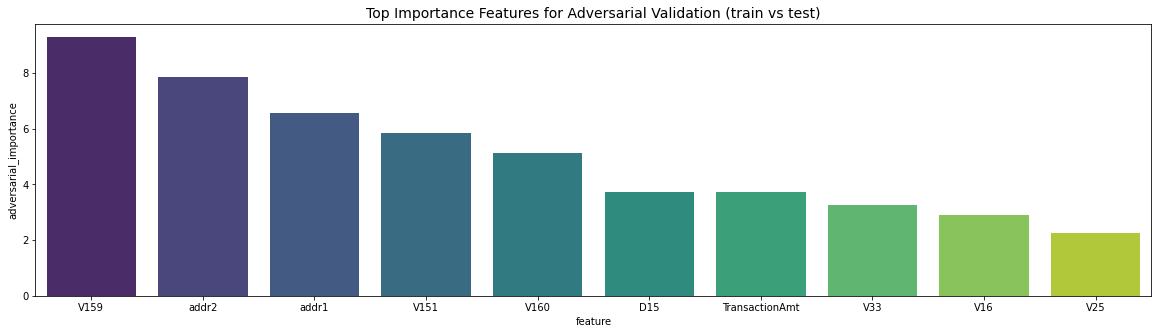

In [269]:
importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)

In [ ]:
# Ещё не успел доделать.

#### Задание 5:
Сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных;